In [1]:
import pandas
import timeit
import datetime
import math
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from collections import defaultdict
start = timeit.default_timer()
delivery_info=pandas.read_csv("~~~/testdata.csv")

In [2]:
datetimeFormat = '%m/%d/%Y %H:%M'
max_delay=440
max_delivery_delay=2700
min_time=datetime.datetime.strptime(delivery_info.iloc[0]['created_at'], datetimeFormat).timestamp()

In [3]:
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c*r

In [4]:
def get_travel_seconds(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat2, lon2)*1000/4.5

In [5]:
def calculate_travel_time (data_frame):
    travel_time={}
    for i in range (0, len(data_frame)):
        for j in range (0, len(data_frame)):
            if i==0 or i==j:
                travel_time[(i,j)]=0
            else:
                lat1=data_frame.iloc[i]['lat']
                lon1=data_frame.iloc[i]['long']
                lat2=data_frame.iloc[j]['lat']
                lon2=data_frame.iloc[j]['long']
                travel_time[(i,j)] = get_travel_seconds(lat1, lon1, lat2, lon2) #travel time in seconds
    return travel_time
    

In [6]:
def input_data_optimization(region):
    pickup_node=region[['delivery_id','pickup_lat','pickup_long','food_ready_time','created_at']]
    dropOff_node=region[['delivery_id','dropoff_lat','dropoff_long']]
    all_nodes=pandas.DataFrame()
    all_nodes2=pandas.DataFrame()
    all_nodes[['lat', 'long']]=pickup_node[['pickup_lat','pickup_long']]
    all_nodes2[['lat', 'long']]=dropOff_node[['dropoff_lat','dropoff_long']]
    all_nodes=all_nodes.append(all_nodes2,ignore_index=True)
    origin=pandas.DataFrame({'lat':0, 'long':0}, index=[0])
    destination=pandas.DataFrame({'lat':0, 'long':0}, index=[0])
    all_nodes=pandas.concat([origin, all_nodes,destination],ignore_index=True)
    time={}
    time=calculate_travel_time (all_nodes)
    return pickup_node,dropOff_node,all_nodes,time 

In [7]:
# time={}
# pickup_node,dropOff_node,all_nodes,time=input_data_optimization(region)

Optimization Model Summary

Decision variables: A formulation for the pickup and delivery problem with time windows, based on a modeling strategy that allows the assignment of vehicles to routes explicitly in two-index flow formulations. 
x_ij be a binary variable equal to 1 if and only if dasher travels an arcs i,j. 
B_i variables decides the time at which vehicle begins service at node i

An additional variable (v_i ) is used to identify the routes by storing the index of the first node that is visited in the route. Hence, pickup and delivery nodes for the same request must have the same identifier (i.e.,the same stored index).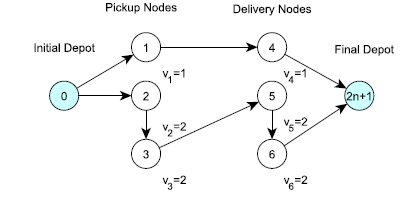 Above figure illustrates the values of the variables v_i using an example with three requests. Nodes 1, 2 and 3 are the pickup locations of delivery nodes 4, 5 and 6, respectively. Two routes are used to service the requests. The first route starts visiting node 1, and hence, vi = 1 for all nodes i in this route (v1 = v4 = 1). Similarly, the second route starts visiting node 2, and hence, we have vi = 2 for all nodes in the route (v2 = v3 = v5 = v6 = 2). Note that all routes share the same origin and destination depot;

The objective function minimizes the total routing cost 

This optimization model has following set of constratints: 

Constraints that guarantee that each pickup-delivery node is visited exactly once;Constraints that gurantee that dasher can't pick delivery until food ready time; The precedence and pairing relations constraints; Constraints guarantee that there are no subtours in the solutions; trivial variable fixations constraints are added, to speed up the running times. Basically this constraints eliminate invalid assignments 

In [8]:
def build_model (pickup_node,dropOff_node,all_nodes,time, region): 
#     time={}
#     pickup_node,dropOff_node,all_nodes,time=input_data_optimization(region)
    datetimeFormat = '%m/%d/%Y %H:%M'
    bigM=999999999999
    planning_time=9000
    node_range=range(0,len(all_nodes))
    tm = Model(name='VRP')
    x = tm.binary_var_matrix(node_range,node_range, name="X") # 1= vehicle  visit arc i,j;
    B = {(i):tm.continuous_var(name='B_{0}'.format(i)) for i in node_range} # visiting time of node i 
    V = {(i):tm.continuous_var(name='V_{0}'.format(i)) for i in node_range} #decision variable that is equal to the index of the first node in the route that visits
    n=len(region) #total number of pickup/drop-off location
    
    #The objective function minimizes the total routing cost 
    total_delivery_duration=tm.sum(x[i,j]*time[i,j] for i in node_range for j in node_range)
    tm.minimize(total_delivery_duration)
    
    #Writing constraints that guarantee that each pickup-delivery node is visited exactly once  
    for i in range(1,len(all_nodes)-1):
        tm.add_constraint(tm.sum(x[i,j] for j in node_range)==1)
    for j in range(1,len(all_nodes)-1):
        tm.add_constraint(tm.sum(x[i,j] for i in node_range)==1)
        
    #constraints that gurantee that dasher can't pick delivery until food ready time and needs to pick up within a time horizon
    for i in node_range:
        for j in node_range:
            if(i!=j):
                tm.add_constraint(B[j]>=B[i]+time[i,j]*x[i,j]-bigM*(1-x[i,j]))
                
                
    for i in range(1,len(pickup_node)+1):
        tm.add_constraint(B[i]>=datetime.datetime.strptime(pickup_node.iloc[i-1]['food_ready_time'],datetimeFormat).timestamp()\
                          -min_time)
        tm.add_constraint(B[i]<=datetime.datetime.strptime(pickup_node.iloc[i-1]['food_ready_time'],datetimeFormat).timestamp()\
                          +max_delay-min_time)
        tm.add_constraint(B[i+n]<=datetime.datetime.strptime(pickup_node.iloc[i-1]['food_ready_time'],\
                                                             datetimeFormat).timestamp()+max_delivery_delay-min_time)
        tm.add_constraint(B[i+n]>=B[i]+time[i,i+n])
        tm.add_constraint(B[i+n]<=planning_time)
        
    #To ensure that paired pickup and delivery nodes will be in the same route, below constraints are added    
    for i in range(1,len(pickup_node)+1):
        tm.add_constraint(V[i+n]==V[i])
        
    #In addition, we must state constraints that guarantee the consistency of the variables v_i in the model.
    #To ensure that the route identifier is taken as the index of the first visited node, we use the following two set of constraints.
    #If node j ∈ P ∪ D is the first node of a route, we have x_0j = 1 and thus the two corresponding constraints together 
    #enforce that v_j = j.On the other hand, if j is not the first node of any route, then x_0j = 0 and 
    #it turns off the corresponding constraints (as together they impose the trivial bounds 0 ≤ v_j ≤ n). 
    
    for j in range(1,len(all_nodes)-1):
        tm.add_constraint(V[j]>=j*x[0,j]) 
        tm.add_constraint(V[j]<=j*x[0,j]-n*(x[0,j]-1))
        
        
    #We also must ensure that the index of the first node is forwarded to the next nodes in the route.We can do so by 
    #imposing the following two sets of constraints.This way, if there is a route that visits a node i and travels directly
    #to a node j,then x_ij = 1 and the corresponding constraints imply that vj = vi. Otherwise, we have x_ij = 0, 
    #which turns off the corresponding constraints. Note that the variables v_i are implicitly integer due to these 
    #sets of constraints
    for j in range(1,len(all_nodes)-1):
        for i in range(1,len(all_nodes)-1):
            tm.add_constraint(V[j]>=V[i]+n*(x[i,j]-1))
            tm.add_constraint(V[j]<=V[i]+n*(1-x[i,j]))
            
    #Following trivial variable fixations constraints are added, to speed up the running times. 
    #Basically this constraints eliminate invalid assignments
    for i in node_range:
        tm.add_constraint(x[i,i]==0)#no travel within same node
        tm.add_constraint(x[i,0]==0) #no travel any node to origin
        tm.add_constraint(x[2*n+1,i]==0)#no travel from final depot node to pickup                   

    for i in range(1,len(pickup_node)+1):
        tm.add_constraint(x[n+i,i]==0) #no travel from delivery to pick up
        tm.add_constraint(x[0,n+i]==0) #no travel from origin to delivery
        tm.add_constraint(x[i,2*n+1]==0)#no travel from final depot node to pickup

    for i in range(1,len(all_nodes)-1):
        for j in range(1,len(all_nodes)-1):
            if(i!=j):
                if(i<=n and j<=n): #invalid assignment from pick to pickup
                    if(datetime.datetime.strptime(pickup_node.iloc[i-1]['food_ready_time'],datetimeFormat).timestamp()-min_time+\
                       time[i,j]<datetime.datetime.strptime(pickup_node.iloc[j-1]['food_ready_time'],\
                                                            datetimeFormat).timestamp()-min_time):
                        tm.add_constraint(x[i,j]==0)
                    if(datetime.datetime.strptime(pickup_node.iloc[i-1]['food_ready_time'],datetimeFormat).timestamp()-min_time+\
                       time[i,j]>datetime.datetime.strptime(pickup_node.iloc[j-1]['food_ready_time'],\
                                                            datetimeFormat).timestamp()-min_time+max_delay):
                        tm.add_constraint(x[i,j]==0)

                if(i<=n and j>n): #invalid assignment from pickup to delivery

                    if(datetime.datetime.strptime(pickup_node.iloc[i-1]['food_ready_time'],datetimeFormat).timestamp()-min_time+\
                       time[i,j]>datetime.datetime.strptime(pickup_node.iloc[j-n-1]['food_ready_time'],\
                                                            datetimeFormat).timestamp()-min_time+max_delivery_delay):
                        tm.add_constraint(x[i,j]==0)

                if(i>n and j>n): #invalid assignment from pickup to delivery
                    if(datetime.datetime.strptime(pickup_node.iloc[i-n-1]['food_ready_time'],datetimeFormat).timestamp()-min_time\
                       +max_delivery_delay+
                       time[i,j]>datetime.datetime.strptime(pickup_node.iloc[j-n-1]['food_ready_time'],\
                                                            datetimeFormat).timestamp()-min_time+max_delivery_delay):
                        tm.add_constraint(x[i,j]==0)

                if(i>n and j<=n): #invalid assignment from delivery to pickup
                    if(datetime.datetime.strptime(pickup_node.iloc[i-n-1]['food_ready_time'],datetimeFormat).timestamp()-min_time\
                       +max_delivery_delay+
                       time[i,j]>datetime.datetime.strptime(pickup_node.iloc[j-1]['food_ready_time'],\
                                                            datetimeFormat).timestamp()-min_time+max_delivery_delay):
                        tm.add_constraint(x[i,j]==0)
    return tm,x,B,V 
                        
        

                

Conduting a depth first search to print each route

In [9]:
# tm,x,B,V =build_model (pickup_node,dropOff_node,all_nodes,time, region)

In [10]:
def recursive_dfs(graph, source,path = []):
    if source not in path:
        path.append(source)
        if source not in graph:# leaf node, backtrack
            return path
        for neighbour in graph[source]:
            path = recursive_dfs(graph, neighbour, path)
    return path

In [11]:
def run_model(tm,x,B,V, region,benders_parameter, gap): 
    #tm,x,B,V =build_model (pickup_node,dropOff_node,all_nodes,time, region)
    tm.parameters.mip.tolerances.mipgap = gap
    tm.parameters.benders.strategy =benders_parameter 
    tms = tm.solve(log_output=False)
    assert tms is not None, "model can't solve"
    
    graph = defaultdict(list)
    source_node=[]
    for i in range (len(region)+len(region)+2):
        for j in range (len(region)+len(region)+2):
            if(x[i,j].solution_value>.4):
                graph[i].append(j)
                if(i==0):
                    source_node.append(j)

    output=pandas.DataFrame()
    pandas.options.display.float_format = '{:.2f}'.format
    count=0
    route_time=[]
    for i in source_node:
        path = recursive_dfs(graph, i)
        route_time.append(B[path[-2]].solution_value-B[i].solution_value)
        count2=0
        for j in path:
            if j<=len(region):
                s='Pickup'
                index=j
            else:
                s='DropOff'
            if(j<2*len(region)+1):
                output=output.append(pandas.DataFrame({"Route ID":count, "Route Point Index":count2,
                                                   "Delivery ID":region['delivery_id'].iloc[index-1],
                                                             "Route Point Type":s,
                                                               "Route Point Time":B[j].solution_value+min_time
                                                  },index=[0]),ignore_index=True)
                count2=count2+1
        path.clear()
        count=count+1   
    total_delivery_duration=0
    for i in range(1,len(region)+1):
        total_delivery_duration=total_delivery_duration+B[i+len(region)].solution_value- (datetime.datetime.strptime(region.iloc[i-1]['created_at'],datetimeFormat).timestamp()-min_time)

    Average_delivery_duration=total_delivery_duration/(len(region))/60
    time_delay_factor_unix_to_UTC=25200
    output['Route Point Time']=output['Route Point Time']-time_delay_factor_unix_to_UTC
    
    return output,Average_delivery_duration, route_time

In [12]:
# output,Average_delivery_duration=run_model(tm,x,B,V, region,0, .8)

In [13]:
if __name__ == '__main__':
    start = timeit.default_timer()
    #Solving separate optimiztion problem for each region and combined the results to generate final output 
    region1=delivery_info[delivery_info.region_id==9] #82, 70, 9
    region2=delivery_info[delivery_info.region_id==70] #82, 70, 9
    region3=delivery_info[delivery_info.region_id==82] #82, 70, 9
    print("Preparing input data")
    
    #solve region1:
    output1=pandas.DataFrame()
    benders_parameter=0
    sol_gap=.8
    time={}
    pickup_node,dropOff_node,all_nodes,time=input_data_optimization(region1)
    tm,x,B,V =build_model (pickup_node,dropOff_node,all_nodes,time, region1)
    output1,Average_delivery_duration_1,route_time_1=run_model(tm,x,B,V, region1,benders_parameter, sol_gap)
    last_path_id=output1['Route ID'].iloc[len(output1)-1]
    
    #solve region2:
    time={}
    benders_parameter=3
    sol_gap=.8286
    output2=pandas.DataFrame()
    pickup_node,dropOff_node,all_nodes,time=input_data_optimization(region2)
    tm,x,B,V =build_model (pickup_node,dropOff_node,all_nodes,time, region2)
    output2,Average_delivery_duration_2,route_time_2=run_model(tm,x,B,V, region2,benders_parameter, sol_gap)
    output2['Route ID']=output2['Route ID']+last_path_id
    last_path_id=output2['Route ID'].iloc[len(output2)-1]
    
    
    #solve region3:
    time={}
    benders_parameter=3
    sol_gap=.9332
    output3=pandas.DataFrame()
    pickup_node,dropOff_node,all_nodes,time=input_data_optimization(region3)
    tm,x,B,V =build_model (pickup_node,dropOff_node,all_nodes,time, region3)
    output3,Average_delivery_duration_3,route_time_3=run_model(tm,x,B,V, region3,benders_parameter, sol_gap)
    output3['Route ID']=output3['Route ID']+last_path_id
    
    #merge all output 
    output=pandas.DataFrame()
    output=pandas.concat([output1, output2,output3],ignore_index=True)
    #calculate service level: aveage delivery duration 
    average_delivery_duration=(Average_delivery_duration_1*len(region1)+Average_delivery_duration_2*len(region2)+\
                              Average_delivery_duration_3*len(region3))/len(delivery_info)
    
    #calculated average deliveries per hour
    Sum=(sum(route_time_1)+sum(route_time_2)+sum(route_time_3))/3600 #total hour of each path 
    average_deliveries_per_hour=len(delivery_info)/Sum
    
    print(average_delivery_duration,average_deliveries_per_hour)
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    output.to_csv('C:/Users/RONIMS/Documents/FY-21/MSC/DoorDash/Ops Research Scientist/output.csv', index=False)

Preparing input data
41.804422270960664 4.134146978584694
Time:  149.63661240000002
